In [1]:
%matplotlib inline
from __future__ import print_function

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2
 
from utils.nolearn_net import NeuralNet
from utils.data_utils import *
from utils.iterator import BaseBatchIterator

/Users/cthorey/miniconda2/envs/fognet/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


# Load data 

In [2]:
data = load_raw_data()

# Preprocessing 

The training set consist of measurements every 2 hours on the station.
While the lag between most of measurements is 2h, some of them show a larger time difference.
We first use that to define some group in the training set.

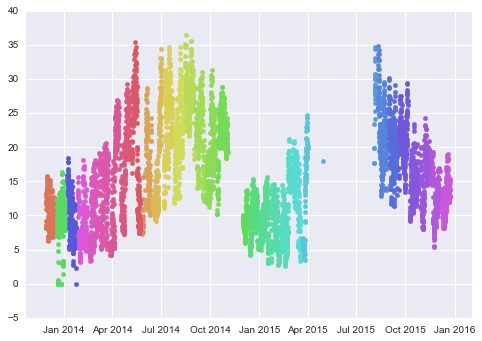

In [3]:
df_train =  add_group_column_to_data(data['micro_train'])
i= 0
for key,gp in df_train.groupby('group'):
    plt.scatter(gp.index,gp.temp,color = sns.color_palette('hls',len(df_train.groupby('group')))[i])
    i+=1

## Train/Val/Test split

We are going to split that thing in three different group train/val/test

- I take the 20 first group for training
- I take the 7 that follows for validation
- I take the 8 remaining for testing

In [4]:
train,val,test = train_val_test_split(data['micro_train'],data['labels'])

Le train is composed by 19 group and 3354 observation
Le val is composed by 7 group and 1083 observation
Le test is composed by 8 group and 1361 observation


## Processing to feed the data to a RNN 

In [5]:
from sklearn.preprocessing import Imputer
inputer = Imputer(strategy='mean')
inputer.fit(train[train.columns[:-2]])
def df_transform(inputer,df):
    df_tmp = pd.DataFrame(inputer.transform(df[df.columns[:-2]]),
                          columns = df.columns[:-2],
                          index = df.index)
    return df_tmp.join(df[df.columns[-2:]])

In [6]:
train_tmp = df_transform(inputer,train)
val_tmp = df_transform(inputer,val)
batch_iterator = BaseBatchIterator(feats=train.columns.tolist()[:-2],
                                   label='yield',
                                   batch_size=5,
                                   size_seq=24,
                                   stride=1)
batch_iterator_train = batch_iterator(train_tmp)
batch_iterator_val = batch_iterator(val_tmp)

# RNN MODEL 

In [7]:
import theano.tensor as TT 
import lasagne
## Parameters
# batch size : N
# Seq length : T
# Num features : D
# Size hidden layer

D = 9
H = 100
GRAD_CLIP = 10
# First, we build the network, starting with an input layer
# Recurrent layers expect input of shape
# (batch size, SEQ_LENGTH, num_features)

l_in = lasagne.layers.InputLayer(name='in', 
                                 shape=(None, None, D))
batchsize, seqlen, _ = l_in.input_var.shape

# We now build the LSTM layer which takes l_in as the input layer
# We clip the gradients at GRAD_CLIP to prevent the problem of exploding
# gradients.

l_lstm = lasagne.layers.LSTMLayer(l_in, 
                                     H,
                                     name='lstm',
                                     grad_clipping=GRAD_CLIP,
                                     nonlinearity=lasagne.nonlinearities.tanh)
l_shp = lasagne.layers.ReshapeLayer(l_lstm, (-1, H))
l_dense = lasagne.layers.DenseLayer(l_shp, 
                                    num_units=1,
                                   name = 'dense',
                                   nonlinearity = lasagne.nonlinearities.identity)
l_out = lasagne.layers.ReshapeLayer(l_dense, (batchsize, seqlen))

In [ ]:
from utils.nolearn_net import NeuralNet
net = NeuralNet(
    layers=l_out,
    regression=True,
    objective_loss_function=lasagne.objectives.squared_error,
    objective_l2=1e-7,
    update=lasagne.updates.adam,
    update_learning_rate=1e-4,
    train_split = False,
    batch_iterator_train=batch_iterator_train,
    batch_iterator_test=batch_iterator_val,
    verbose=15,
    max_epochs=10000,
)

net.fit(epochs = 8000)

# Neural Network with 44401 learnable parameters

## Layer information

  #  name    size
---  ------  --------
  0  in      Nonex9
     lstm    Nonex100
             100
     dense   1
             None

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       6.67494       6.23939      1.06981  3.49s
      2       6.59233       6.22900      1.05833  3.22s
      3       6.57702       6.19952      1.06089  3.50s
      4       6.50290       6.17295      1.05345  3.27s
      5       6.50410       6.11318      1.06395  3.15s
      6       6.51756       6.12122      1.06475  3.26s
      7       6.49019       6.08330      1.06689  3.22s
      8       6.44550       6.07713      1.06062  3.18s
      9       6.44072       6.04468      1.06552  3.30s
     10       6.37601       6.01541      1.05995  3.34s
     11       6.35545       6.00494      1.05837  3.25s
     12       6.31979       5.96671      1.05917  3.31s
     13      

In [9]:
net.score()

2.5189195334396266

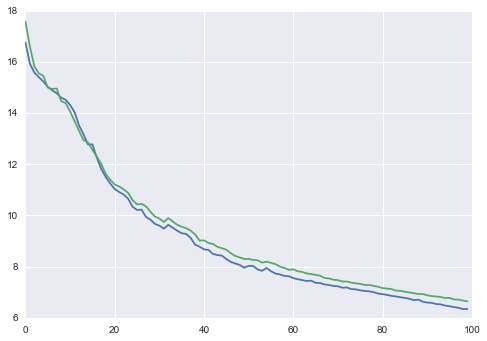

In [10]:
plt.plot([f['valid_loss'] for f in net.train_history_])
plt.plot([f['train_loss'] for f in net.train_history_])

In [2]:
import numpy as np
np.sqrt(3.8)

1.9493588689617927